In [1]:
PROJDIR=file.path('../../../data/raw_data/cross_species_peak_orthologs')

#######################################
### set up libraries and functions ####
ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F, repr.plot.width=14, repr.plot.height=6)
suppressMessages(library(Signac)); suppressMessages(library(Seurat))
suppressMessages(library(harmony))

source('../hal_scripts/narrowPeakFunctions.R')

In [2]:
# # set up future for parallelization
library(future)
library(future.apply)
plan("multiprocess", workers = parallel::detectCores()/4)
options(future.globals.maxSize = 50000 * 1024^2)

# 1) visualize unintegrated species clusters

In [3]:
## load the seurat object
saveRDS_fn = file.path(PROJDIR, 'rdas', 'linkOrthologMatrixSeurat.rds')
obj_seurat = readRDS(file = saveRDS_fn)

An object of class Seurat 
31852 features across 54473 samples within 1 assay 
Active assay: peaks (31852 features, 31852 variable features)
 2 dimensional reductions calculated: lsi, umap

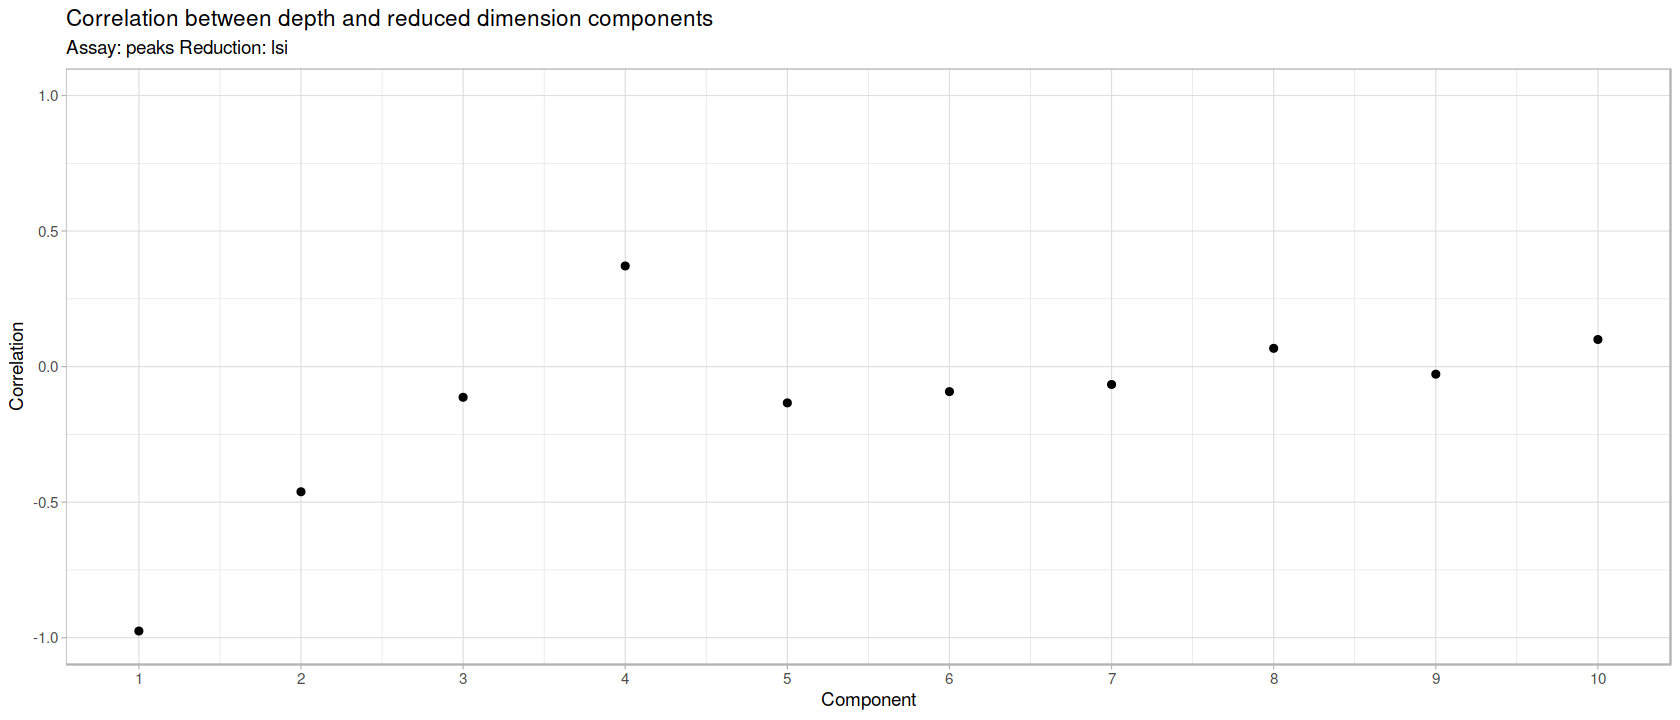

In [4]:
##  TF-IDF, SVD, and UMAP already performed on 'peaks' matrix
obj_seurat
obj_seurat@meta.data$log10nFrags = log10(obj_seurat@meta.data$nFrags)
DepthCor(obj_seurat) # drop the first PC

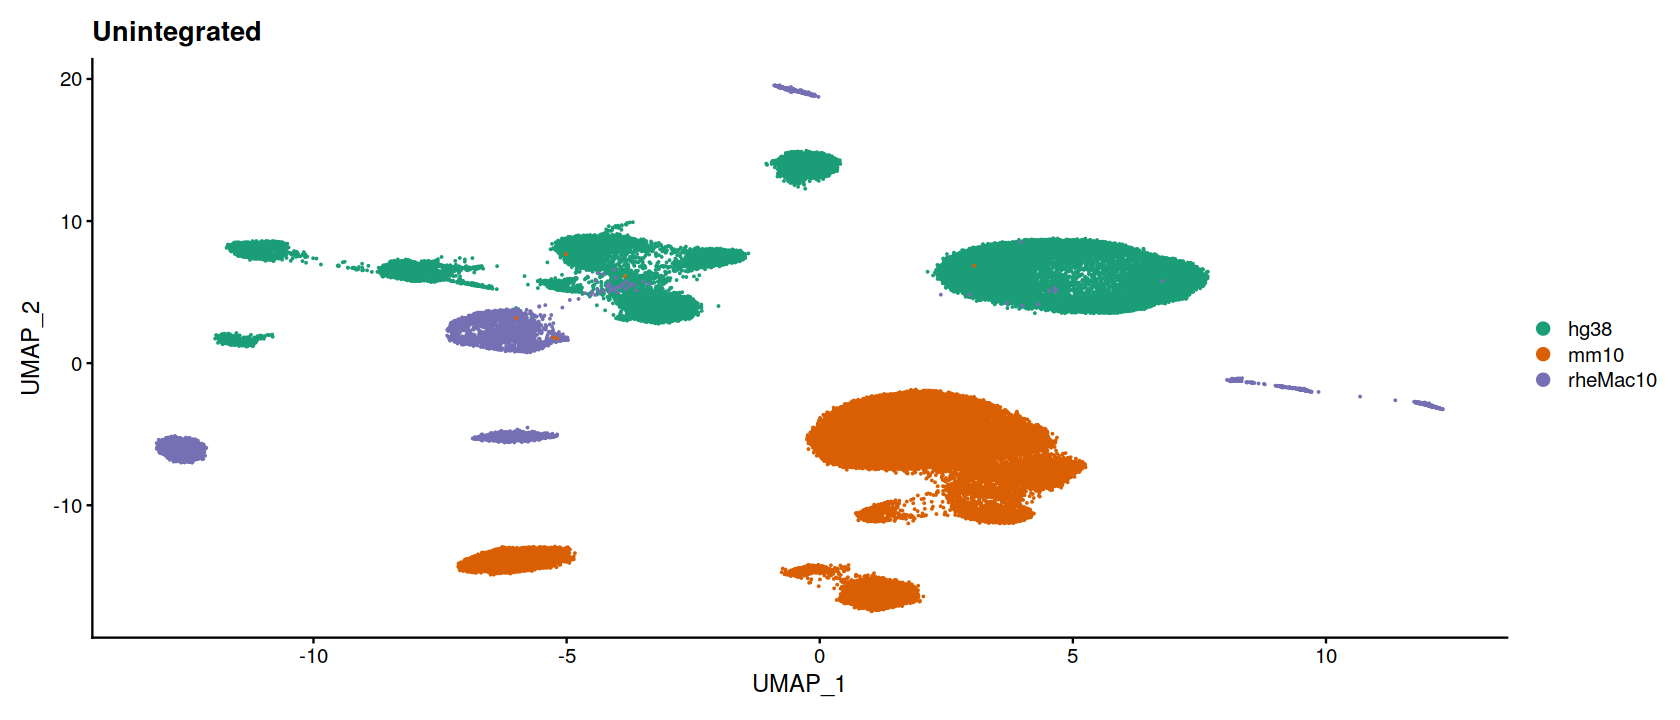

In [5]:
p_unintegrated_species = 
    DimPlot(object = obj_seurat, label = FALSE, group.by = 'Species', cols = 'Dark2') + 
    ggplot2::ggtitle("Unintegrated")
p_unintegrated_species

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."


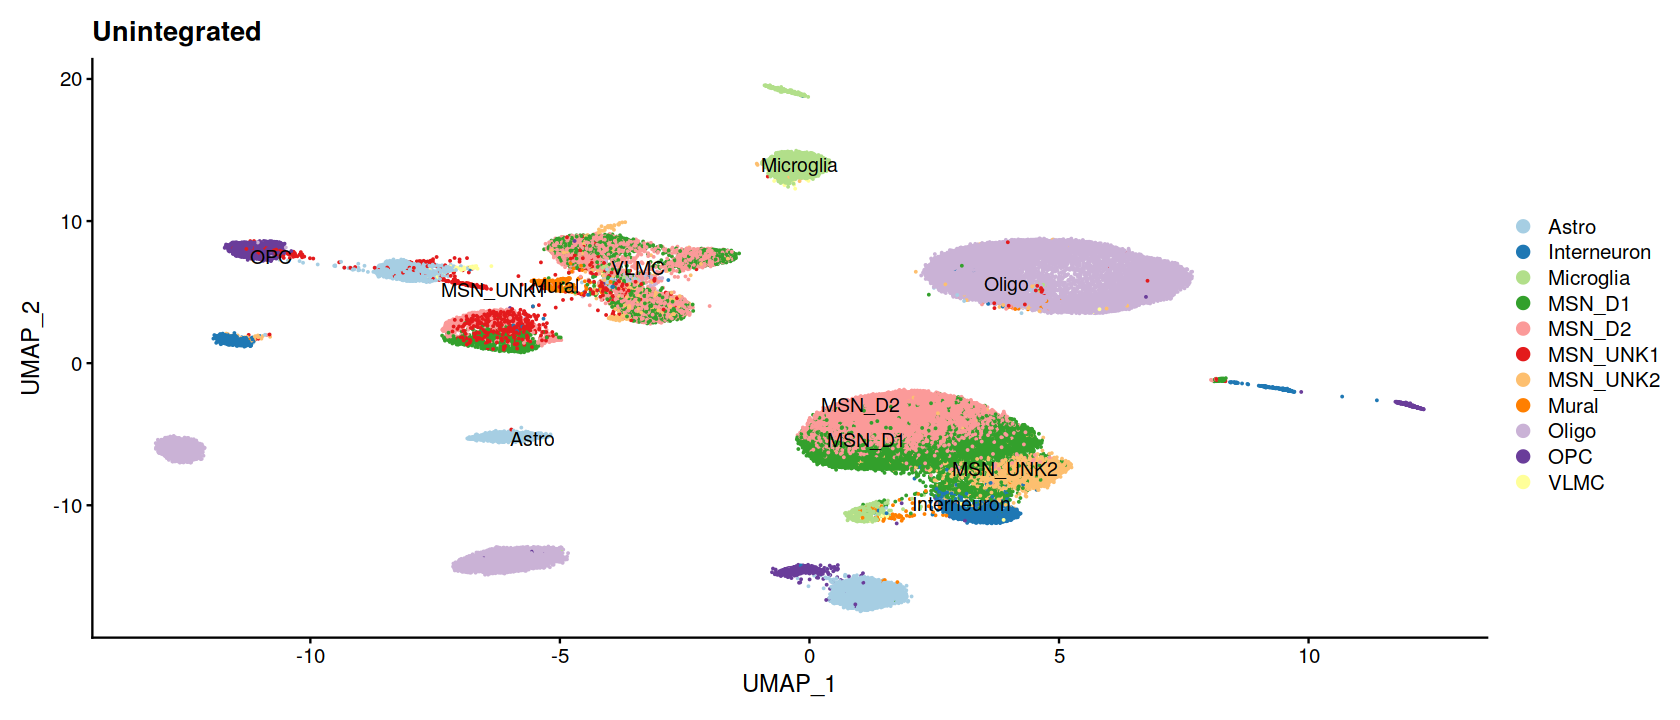

In [6]:
p_unintegrated_clusters2 = 
    DimPlot(object = obj_seurat, label = TRUE, group.by = 'Clusters2', cols = 'Paired') + 
    ggplot2::ggtitle("Unintegrated")
p_unintegrated_clusters2

# 2) integration with Harmony

In [24]:
set.seed(42)
group.by.vars = c('Species','TSSEnrichment'); theta = c(1, 2)
# group.by.vars = c('Species','TSSEnrichment','log10(nFrag)'); theta = c(1, 2, 2)
group.by.vars = c('Species'); theta = c(.2)

objHarmony <- RunHarmony(
    obj_seurat, group.by.vars = group.by.vars, theta = theta, nclust = 20,
    reduction.save = "harmony", reduction = "lsi", dims.use = 2:30, assay.use = "peaks",
    project.dim = FALSE, max.iter.harmony = 20, max.iter.cluster = 30)

Harmony 1/20

Harmony 2/20

Harmony 3/20

Harmony converged after 3 iterations



In [25]:
# re-compute the UMAP using corrected LSI embeddings
objHarmony <- RunUMAP(object = objHarmony, umap.method = "uwot", 
                      verbose = FALSE, reduction = 'harmony', dims = 2:30)

title = paste("Harmony",
              "group:", paste(group.by.vars, collapse = ', '),
              'theta:',paste(theta, collapse = ', '))

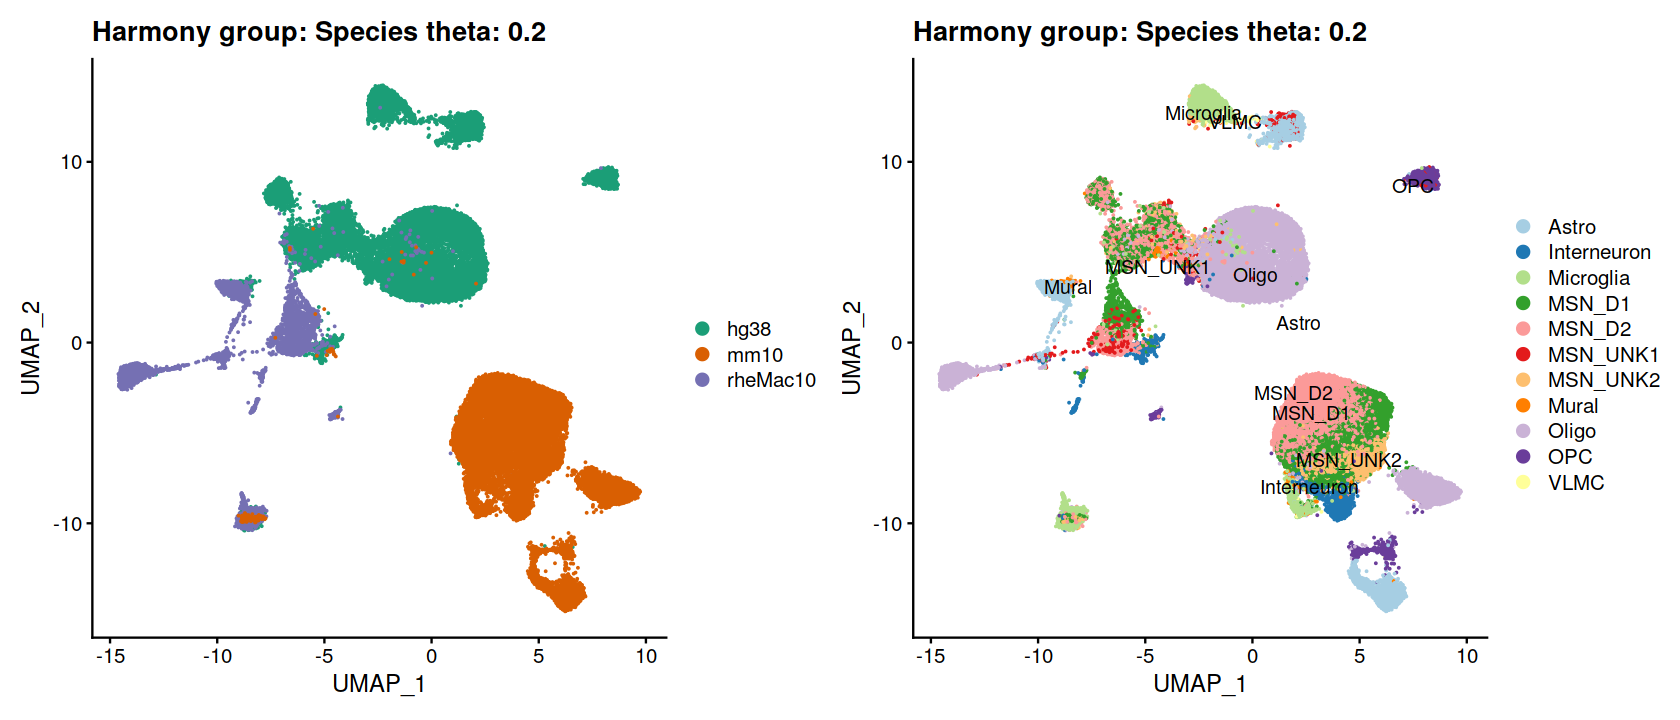

In [26]:
# plot embeddings
p_integrated_species = 
    DimPlot(object = objHarmony, label = FALSE, group.by = 'Species', cols = 'Dark2') +
    ggplot2::ggtitle(title)

p_integrated_clusters2 = 
    DimPlot(object = objHarmony, label = TRUE, group.by = 'Clusters2', cols = 'Paired') +
    ggplot2::ggtitle(title)

p_integrated_species + p_integrated_clusters2

# 3) integration with Seurat CCA

In [ ]:
## load the seurat object
integratedRDS_fn = file.path(PROJDIR,'rdas','linkOrthologIntegratedSeurat.rds')
integrated = readRDS(file = integratedRDS_fn)

In [ ]:
# plot embeddings
p_seuratIntegration_species = 
    DimPlot(object = integrated, label = FALSE, group.by = 'Species', cols = 'Dark2') +
    ggplot2::ggtitle('Seurat CCA Integration')

p_seuratIntegration_clusters2 = 
    DimPlot(object = integrated, label = TRUE, group.by = 'Clusters2', cols = 'Paired') +
    ggplot2::ggtitle('Seurat CCA Integration')

p_seuratIntegration_species + p_seuratIntegration_clusters2